# Solar gain model
This notebook demonstrates how to use the solar gain model

In [33]:
from buildingmodel import data_path
from buildingmodel.main import Parameters, load_data, run_inference, run_creation
from buildingmodel.io.gis import load_data as load_gis_data
from buildingmodel.io.climate import load_data as load_climate_data
from buildingmodel.models.climate import run_models as run_climate_models
from buildingmodel.creation.boundary import run_creation as run_boundary_creation
from buildingmodel.models.solar_masks import run_models as run_solar_mask_models
from buildingmodel.models.solar_gains import run_models as run_solar_gain_models
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [34]:
parameters = Parameters(
    districts="districts_test_sample.gpkg",
    district_level_census="district_level_census_test_sample.hdf",
    district_level_diagnosis="district_level_diagnosis_data_test_sample.hdf",
    gas_network_route="gas_network_route_sample.gpkg",
    simplification_tolerance=0.1,
)

building_data = Path(data_path["gis"]) / "testing" / "test_sample.gpkg"
climate_data = Path(data_path["climate"]) / "Brest.epw"

Running the boundary, climate, mask and solar gains models

In [35]:
buildings, climate, metadata = load_data(building_data, climate_data, parameters)
buildings, boundaries, dwellings = run_creation(buildings, parameters)
dwellings, buildings = run_inference(buildings, dwellings, boundaries, parameters)
run_climate_models(climate, metadata, parameters)
run_solar_mask_models(buildings, boundaries, parameters)
run_solar_gain_models(buildings, boundaries, climate, parameters)

/home/yassine/miniconda3/envs/buildingmodel_dev/lib/python3.8/site-packages/topojson/core/cut.py:112: ShapelyDeprecationWarning: STRtree will be changed in 2.0.0 and will not be compatible with versions < 2.
  tree_splitter = STRtree(mp)


The results of solar gain model (in kWh) are stored in the 'transmitted_solar_gain' columns of the boundary GeoDataframe

In [38]:
boundaries["transmitted_solar_gain"]

0       5.752385
1       6.483437
2       7.434663
3      41.387879
4       6.768811
         ...    
219     0.000000
220     0.000000
221     0.000000
222     0.000000
223     0.000000
Name: transmitted_solar_gain, Length: 177, dtype: float64

To display comparable values, we calculate the solar gains by area as well as the average mask by boundary

In [39]:
boundaries["solar_gain_by_area"] = (
    boundaries["transmitted_solar_gain"] / boundaries["area"]
)
mask_columns = [
    col_name for col_name in boundaries.columns if col_name.startswith("mask_")
]
boundaries["average_mask"] = boundaries[mask_columns].mean(axis=1)

In [40]:
walls = pd.DataFrame(
    boundaries.loc[
        boundaries["type"] == 0, ["solar_gain_by_area", "azimuth", "average_mask"]
    ]
)

We plot the solar gains by area as a function of the azimuth, with color fo the points depending of the average mask

<Axes: xlabel='azimuth', ylabel='solar_gain_by_area'>

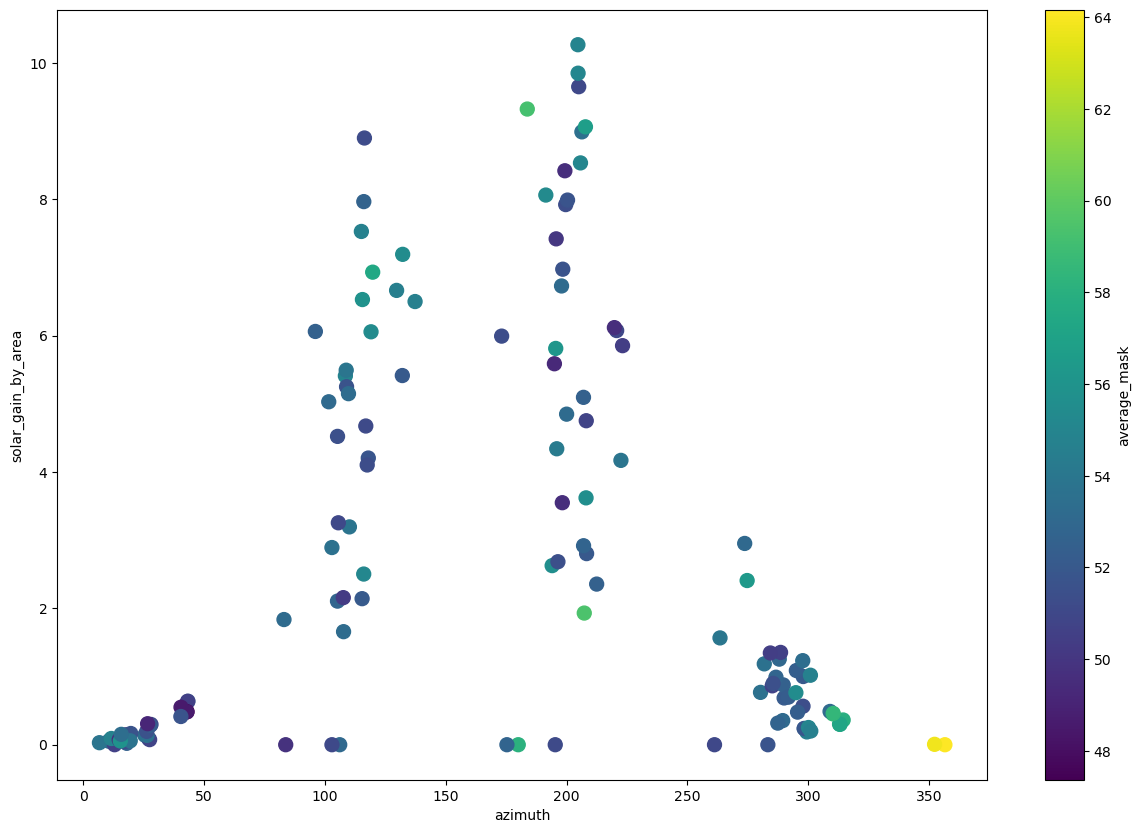

In [41]:
walls.plot.scatter(
    x="azimuth",
    y="solar_gain_by_area",
    c="average_mask",
    colormap="viridis",
    s=100,
    figsize=(15, 10),
)